Dependencies
-

In [1]:
#DFEST & Synthetic Ground Truth Model Dependencies

#sys.path.append('/tmpscratch/skelly26/.local/bin')
#sys.path.append('/tmpscratch/skelly26/.local/lib/python3.8/site-packages')

import sys
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install matplotlib

import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
#from deepctr.models import DeepFM
#from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

from sklearn.metrics import log_loss, roc_auc_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib

import time
import sys

import tensorflow as tf
from tensorflow.python.keras.models import  save_model,load_model
from tensorflow.keras import layers
#from deepctr.layers import custom_objects

import numpy as np
import math
from collections import deque
import random
import heapq

import scipy

Define Structure of Feature Space as a Graph
-

In [2]:
class Node:
    def __init__(self, position, distance):
        
        #Position list([row, column])
        self.position = position # [n1, n2, ..., n|N|]
        self.distance = distance #Distance for evaluation function to compare nodes in priority queue
        
  # Nodes with the same distance
    def __eq__(self, other):
        return isinstance(other, Node) and self.distance == other.distance
  
    # Node is less than other node
    def __lt__(self, other):
        return isinstance(other, Node) and self.distance < other.distance

    # Node is greater than other node
    def __gt__(self, other):
        return isinstance(other, Node) and self.distance > other.distance

Calculate Feature-Interaction Cluster
-

In [3]:
# Puts solution node into a n-way feature interaction cluster, and tell which cluster
def cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler):
    
    #print("query_node1",query_node.position, "source_node1",source_node.position)
    soln_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
                
    if tuple(soln_cluster) not in solution_clusters:
        solution_clusters[tuple(soln_cluster)] = []

    solution_clusters[tuple(soln_cluster)].append(query_node.position)
    
    return solution_clusters #returns full cluster list


def calc_feat_cluster(source_node, query_node, feat_scaler):
    
    relative_node_pos = (query_node.position - source_node.position) #Projects pos of query relative to source
    scaled_feats = (relative_node_pos * feat_scaler) #[0] #Scales features to same scale of distance
    f_max = np.argmax(abs(scaled_feats)) #Most dominant feature in solution
    soln_cluster = np.zeros(len(feat_ranges)) #Marks which feature interaction was expressed by the node position
    
    #Loop through each feature of a single solution, and determine degree of multi-feature interaction
    for f_i in range(len(scaled_feats)):
        
        if abs(scaled_feats[f_max]/scaled_feats[f_i]) <= 2:
            if scaled_feats[f_i] > 0:
                soln_cluster[f_i] = 1
            else:
                soln_cluster[f_i] = -1
    
    if scaled_feats[f_max] > 0:
        soln_cluster[f_max] = 1
    else:
        soln_cluster[f_max] = -1
        
    return soln_cluster.astype(int)

Define Synthetic Model (Global)
-
Given d-dimensional feature space, the synthetic_model() mathemtatically defines a ground truth decision boundary, such that all points within the bounds of a solution cluster are all a distance r from the source node position

Generate Uniform Distribution of Unit Vectors in d-dimensional space
---

In [4]:
def generate_unit_vectors(nfeats,nvectors=1):

    #np.random.seed(3)
    vectors = []
    for _ in range(nvectors):
        v = np.random.uniform(low=-1, high=1, size=(nfeats,))
        #v_hat = v / np.linalg.norm(v)
        vectors.append(v)
    return vectors

Find k-way Feature-Interaction Solutions Surrounding Source Node
---

In [421]:
def generate_precursor_solutions(source_node, feat_ranges, k_prelim=20, nsteps=100):
    
    #plt.rcParams["figure.figsize"] = (10,10)
    
    feat_ranges = feat_ranges #Ground truth altered boundary of solutions
    feat_range = feat_ranges[0] #debug: gti can't dynamically scale feat proportions
    feat_upscale = len(feat_ranges)
    step_sizes = feat_upscale*feat_ranges/nsteps #How large of a step to take for each respective int feature
    feat_scaler = 1/np.asarray(feat_ranges) #Scale to normalize feature step size when calculating distance
    
    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(feat_ranges)):
        feat_steps.append(np.linspace(step_sizes[feat],step_sizes[feat]*nsteps,nsteps))
    feat_steps = np.asarray(feat_steps)
    
    source_rec = query_nsphere_synth_model(source_node)

    discovered = []

    while len(discovered) < k_prelim:
        
        #print("###########################################################################")
        unit_vector = generate_unit_vectors(len(source_node.position))[0]
        unit_vector = np.sign(np.round(unit_vector)) #Scale randomly generated clusters by appropriate ratio
        for step in range(nsteps-1):
            scaled_vector_position = tuple(np.asarray(unit_vector) * np.asarray(feat_steps.T[step]) + np.asarray(source_node.position))
            #print("         ",scaled_vector_position)
            scaled_vector = Node(scaled_vector_position, None)
            query_rec = query_nsphere_synth_model(scaled_vector)
            
            #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'bd',markersize=10)
            
            if source_rec != query_rec:
                # distance heuristic
                #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'r^',markersize=15)
                scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
                discovered.append(scaled_vector)
                if len(discovered) % 10000 == 0:
                    print(len(discovered),end=' ')
                break
                
    #plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=20)
        
    return discovered #prelim_discovered

Calculate Distance from Source to Query Node
---

In [6]:
def get_distance(source_node, query_node, feat_scaler, distance='Euclidean'):
    #returns distance for ndim feature space
    
    dif = query_node.position - source_node.position
    scaled_dif = dif * feat_scaler
    
    # More efficient at scale
    if distance == 'Manhattan':
        return sum(abs(scaled_dif))
    
    if distance == 'Euclidean':
        dsum = 0
        for feat in dif:
            dsum += feat**2
        return math.sqrt(dsum)

Display Shortest Clusters Found During Outside-In Search
-

In [7]:
def sort_solution_clusters(solution_clusters,source_node,feat_scaler):
    
    all_distances = []
    for key in solution_clusters:
        total_distance = []
        for soln in solution_clusters[key]:
            distance = get_distance(source_node, Node(soln,None), feat_scaler)
            total_distance.append(distance)
        all_distances.append(np.sort(total_distance))
        #print(key,':',(solution_clusters[key] * np.asarray(key)).mean())
        
    sorted_clusters = []
    i = 0
    for key in solution_clusters:
        min_sample = all_distances[i].min()
        sorted_clusters.append((min_sample,key))
        i+=1
    
    sorted_clusters = np.asarray(sorted_clusters)
    ind = sorted_clusters.argsort(axis=0)
    sorted_clusters[:,0] = sorted_clusters[:,0][ind[:,0]]
    sorted_clusters[:,1] = sorted_clusters[:,1][ind[:,0]]
    
    return sorted_clusters

---

Adjacent Cluster Search
-

In [8]:
#Return positions in adjacent solution clusters
def find_adjs(source_node, query_node, feat_scaler):
    
    query_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
    query_cluster = list(query_cluster)
    adj_clusters = []

    #1-way changes are applied to each feature in the query cluster to generate adj clusters
    source_cluster = tuple(np.zeros(len(query_cluster)))
    for dim in range(len(query_cluster)):
        temp = query_cluster.copy()
        if temp[dim] < 1:
            temp[dim] += 1
            if temp != source_cluster:
                adj_clusters.append(temp)
        temp = query_cluster.copy()
        if temp[dim] > -1:
            temp[dim] -= 1
            if temp != source_cluster:
                adj_clusters.append(temp)

    #Normalization to find x_q
    feat_scaler_distance = 0
    for feat in feat_scaler:
        feat_scaler_distance += feat ** 2
    feat_scaler_distance = feat_scaler_distance ** 0.5
        
    adjs = []
    for cluster in adj_clusters:
        
        # n-dimensional euclidean distance to a point in the adj cluster equivalent to the distance
        # from the original query cluster
        # query_node.distance is pre-scaled scaled
        x_q = source_node.position + feat_scaler * np.asarray(cluster) * query_node.distance / feat_scaler_distance
        adj_node = Node(np.asarray(x_q), query_node.distance)
        adjs.append(adj_node)
        
    return adjs  

A* Cluster Search
-

In [422]:
#A* with solution cluster tracking
def a_star_search(source_node, prelim_discovered, feat_ranges, k_astar=100):
    
    #Analytics to inform how to handle degree of branching
    feat_range = feat_ranges[0] #Can't yet use multiple ranges for defining gti
    nodes_generated = 0
    nodes_visited = 0
    
    frontier = [] # Priority Queue
    discovered = [] #Vector of k-closest feature interactions to opposite recommendation
    solution_clusters = {}
    
    #Add solutions from uniformly distributed vectors to priority queue (frontier)
    for soln_node in prelim_discovered:
        heapq.heappush(frontier, soln_node)
        nodes_generated += 1
        
    #Scale to normalize learning rate for each feature
    feat_scaler = 1/np.asarray(feat_ranges)
    
    #Opposite Recommendation as Solutions
    source_rec = query_nsphere_synth_model(source_node)
    # loop till queue is empty, or k solutions were discovered
    while frontier and len(discovered) < k_astar:
 
        # dequeue front node
        query_node = heapq.heappop(frontier)
        #print(node, end=' ')
        nodes_visited += 1
        
        #Check if query node is a solution
        query_rec = query_nsphere_synth_model(query_node)
        if query_rec != source_rec:
            
            feat_cluster = calc_feat_cluster(source_node, query_node, feat_scaler)
            
            if tuple(feat_cluster) not in solution_clusters.keys():
                
                #Finds shortest distance node in cluster, returns solution_clusters with descending solutions
                solution_clusters, min_node = find_cluster_min(solution_clusters, source_node, query_node, feat_scaler, feat_range)
                discovered.append(min_node) #redundant list
                if len(discovered) % 100 == 0:
                    print(len(discovered),end=' ')
                
                #Add adjacents to priority queue before visiting them
                adjs = find_adjs(source_node, min_node, feat_scaler) #Nodes in clusters adjacent to the current node
                for adj_node in adjs:
                    heapq.heappush(frontier, adj_node)
                    nodes_generated += 1
    
    print("\nNodes Visited:",nodes_visited)
    print("Nodes Generated:",nodes_generated)

    return solution_clusters

In [459]:
#Return node with estimated minimum distance from source node
def find_cluster_min(solution_clusters, source_node, query_node, feat_scaler, feat_range, nsteps=500):
    
    plt.rcParams["figure.figsize"] = (10, 10)
    relative_pos = query_node.position - source_node.position
    step_sizes = relative_pos/nsteps #How large of a step to take for each respective int feature

    #Normalized step size for searching every feature
    feat_steps = []
    for feat in range(len(relative_pos)):
        if step_sizes[feat] != 0:
            feat_steps.append(np.linspace(step_sizes[feat],relative_pos[feat],nsteps))
        else:
            feat_steps.append(np.zeros(nsteps))
    for feat in feat_steps:
        np.flip(feat)
    feat_steps = np.asarray(feat_steps)    

    source_rec = query_nsphere_synth_model(source_node)
    query_rec = query_nsphere_synth_model(query_node)
    if source_rec != query_rec:
        solution_clusters = cluster_feat_int(source_node, query_node, solution_clusters, feat_scaler)
    
    min_node = query_node
    for step in range(nsteps-1):
        
        local_feat_step = []
        for feat in range(len(feat_steps)):
            local_feat_step.append(feat_steps[feat][step])
        scaled_vector_position = tuple(np.asarray(query_node.position) - np.asarray(local_feat_step))
        #scaled_vector_position = np.asarray(source_node.position + local_feat_step)
        scaled_vector = Node(scaled_vector_position, None)
        query_rec = query_nsphere_synth_model(scaled_vector)
        
        if source_rec == query_rec:
            #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'g*',markersize=15)
            break
            
        scaled_vector.distance = get_distance(source_node, scaled_vector, feat_scaler)
        min_node = scaled_vector
        solution_clusters = cluster_feat_int(source_node, min_node, solution_clusters, feat_scaler)
        #print(min_node.position,end='')

        #plt.plot(scaled_vector.position[0],scaled_vector.position[1],'m+',markersize=10)
        
    #print(calc_feat_cluster(source_node, min_node, feat_scaler))
    #plt.plot(source_node.position[0],source_node.position[1],'y*',markersize=30)

    return solution_clusters, min_node

In [424]:
#Run A* against ground truth synthetic model

def gd_fits(source_node, feat_ranges, k_prelim=100, k_astar=100):

    plt.rcParams["figure.figsize"] = (40,15)
    
    feat_scaler = 1/np.asarray(feat_ranges)

    start_time = time.time()
    prelim_discovered = generate_precursor_solutions(source_node, feat_ranges, nsteps=4, k_prelim=k_prelim)
    print("\n\nPreliminary Search Time:", time.time()-start_time,'seconds')
    
    start_time = time.time()
    solution_clusters = a_star_search(source_node, prelim_discovered, feat_ranges, k_astar=k_astar)
    print("\n\nA* Cluster Search Time:", time.time()-start_time,'seconds')

    sorted_clusters = sort_solution_clusters(solution_clusters,source_node,feat_scaler)
    #display_instability(sorted_clusters)

    return sorted_clusters

---


LimeTabularExplainer with Synthetic GTI Model
-

Feature Importance Ranking Loss Function
-

In [12]:
def calc_ranking_loss(ktop_gti, query_clusters, d_dims):

    loss = 0
    for gti_cluster in range(len(ktop_gti)):

        min_loss = math.inf
        for q_cluster in range(len(query_clusters)):

            #Penalize difference in ranking position
            ranking_loss = abs(gti_cluster - q_cluster)
            #print(ranking_loss)

            #Penalize difference in cluster composition
            cluster_loss = 0
            for feat in range(len(list(ktop_gti)[gti_cluster])):
                cluster_loss += abs(list(ktop_gti)[gti_cluster][feat] - list(query_clusters)[q_cluster][feat])
            temp_loss = (1 + ranking_loss) * (1 + cluster_loss)

            if temp_loss < min_loss:
                min_loss = temp_loss

        loss += min_loss - 1

    regularized_loss = loss / d_dims / len(ktop_gti)
    
    return regularized_loss

Intialize Synthetic Ground Truth Importance Model
-

In [466]:
np.random.seed(seed=0)
n_dims = 8
source_node = get_source_node(n_dims,boundary_threshold) #Want to explain this value
k_clusters = 8 #Number of sub-maximum decision boundaries generated in ground_truth_importance

feat_ranges = np.zeros(n_dims) + 20 #Assume all features have range 20
feat_range = feat_ranges[0]
feat_scaler = 1 / feat_ranges

In [467]:
sorted_clusters = gd_fits(source_node, feat_ranges, k_prelim=100, k_astar=5000)
sorted_clusters



Preliminary Search Time: 0.005352020263671875 seconds


/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


100 200 300 400 500 600 700 
Nodes Visited: 7385
Nodes Generated: 7385


A* Cluster Search Time: 3.720149040222168 seconds


array([[3.5726957618378052, (1, 1, 1, 1, 1, 1, 0, 1)],
       [3.5946631654399246, (1, 1, 1, 1, 1, 1, 1, 1)],
       [3.6410734713451203, (1, 1, 1, 1, 1, 0, 1, 1)],
       ...,
       [13.120000000000003, (0, -1, -1, 0, -1, 0, -1, 0)],
       [13.129265021317833, (-1, -1, 0, -1, -1, 1, -1, 0)],
       [14.131949617798666, (-1, -1, 0, -1, 0, -1, 0, -1)]], dtype=object)

In [468]:
for query_cluster_slope in sorted_clusters[0:20]:
    distance = gti_cluster_min(source_node, np.asarray(query_cluster_slope[1]))
    print(query_cluster_slope,":",distance)

[3.5726957618378052 (1, 1, 1, 1, 1, 1, 0, 1)] : 3.569124667983523
[3.5946631654399246 (1, 1, 1, 1, 1, 1, 1, 1)] : 3.590624234482413
[3.6410734713451203 (1, 1, 1, 1, 1, 0, 1, 1)] : 3.6359367548873527
[3.7058079710772227 (1, 1, 1, 1, 1, 1, 0, -1)] : 3.704792868174742
[3.7058383148865213 (1, 1, 1, 1, 0, 1, 1, 1)] : 3.7047928681747426
[3.7120976637031635 (1, 1, 1, 0, 1, 0, 1, 0)] : 3.708512478042067
[3.7209848590055916 (1, 1, 1, 1, 1, 1, 1, -1)] : 3.7185281585469934
[3.759955976883306 (1, 1, 1, 0, 1, 1, 0, 1)] : 3.752563456171123
[3.7802545888093615 (1, 1, 1, 0, 1, 1, 1, 1)] : 3.7757643548584476
[3.7814886778512116 (1, 1, 1, 1, 1, 0, 1, -1)] : 3.7757643548584467
[3.831275567770555 (1, 1, 1, 0, 1, 0, 1, 1)] : 3.830907551779409
[3.8386450646044237 (1, 1, 0, 1, 1, 1, 0, 1)] : 3.830907551779409
[3.8525227520329377 (1, 1, 1, 1, 0, 1, 1, -1)] : 3.8489244178558546
[3.8553159803670227 (1, 1, 0, 1, 1, 1, 1, 1)] : 3.848924417855855
[3.857951944581927 (1, 1, 1, 1, 1, 1, -1, 1)] : 3.853886923982833
[3

/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


In [30]:
#Find top k importance clusters

scaled_feats = gti_feature_importance
f_max = np.argmax(abs(scaled_feats)) #Most dominant feature in solution
soln_cluster = np.zeros(len(feat_ranges)) #Marks which feature interaction was expressed by the node position

#Loop through each feature of a single solution, and determine degree of multi-feature interaction
for f_i in range(len(scaled_feats)):

    if abs(scaled_feats[f_max]/scaled_feats[f_i]) <= 2:
        if scaled_feats[f_i] > 0:
            soln_cluster[f_i] = 1
        else:
            soln_cluster[f_i] = -1

if scaled_feats[f_max] > 0:
    soln_cluster[f_max] = 1
else:
    soln_cluster[f_max] = -1

soln_cluster.astype(int)

array([1, 1])

Evaluation of DFEST 
-

In [31]:
sorted_clusters = gd_fits(source_node, feat_ranges, k_prelim=100, k_astar=5000)
i=0
ktop_sorted_clusters = []
for soln in sorted_clusters:
    if i >= k_clusters:
        break
    ktop_sorted_clusters.append(soln)
    i+=1
sorted_solution_clusters = {}
for cluster in ktop_sorted_clusters:
    sorted_solution_clusters[cluster[1]] = cluster[0]
dfest_loss = calc_ranking_loss(ground_truth_importance, sorted_solution_clusters, n_dims)
print("DFEST Loss:",dfest_loss)

#Random Chance Evaluation
random_gti = {}
while len(random_gti) < k_clusters: #len(solution_clusters):
    random_cluster = tuple(np.random.randint(low=-1,high=2, size=n_dims)) 
    if random_cluster not in random_gti.keys():
        random_gti[random_cluster] = np.random.randint(low=0,high=feat_range)
random_loss = calc_ranking_loss(ground_truth_importance, random_gti, n_dims)
print("Random Loss:",random_loss)

#Self Evaluation
self_loss = calc_ranking_loss(ground_truth_importance, ground_truth_importance, n_dims)
print("Self Loss:",self_loss)



Preliminary Search Time: 0.12671399116516113 seconds

Nodes Visited: 103
Nodes Generated: 103


A* Cluster Search Time: 0.009259939193725586 seconds
DFEST Loss: 6.375
Random Loss: 0.875
Self Loss: 0.0


/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars


In [32]:
sorted_solution_clusters

{(-1, 0): 30.0}

In [33]:
ground_truth_importance

{(-1, 0): 30.0,
 (-1, 1): 330.0,
 (0, 1): 480.0,
 (1, 1): 630.0,
 (-1, -1): 660.0,
 (0, -1): 480.0,
 (1, -1): 630.0,
 (1, 0): 660.0}

---

---

In [85]:
#nsphere decision boundary
def query_nsphere_synth_model(query_node):
    
    distance = 0
    for i in range(len(query_node.position)):
        distance += query_node.position[i] ** 2
    distance = distance ** 0.5
    
    if distance < boundary_threshold:
        return 0
    else:
        return 1

In [427]:
np.random.seed(seed=0)
n_dims = 2
origin_node = Node(np.zeros(n_dims),0)

boundary_threshold = 10 #nsphere distance threshold from origin for class 0
feat_range = 20
feat_ranges = np.zeros(n_dims) + feat_range #Assume all features have max range 20
feat_scaler = 1 / feat_ranges

def get_source_node(n_dims,boundary_threshold):
    source_pos = np.linspace(1,n_dims,n_dims)
    source_pos = np.flip(source_pos)
    source_pos = source_pos/np.linalg.norm(source_pos) * boundary_threshold / 1.5
    source_node = Node(source_pos,0) #Want to explain this value
    return source_node

source_node = get_source_node(n_dims,boundary_threshold)
query_nsphere_synth_model(source_node)
print("Source Position:",source_node.position)

Source Position: [5.96284794 2.98142397]


In [389]:
# Solve for optimal cluster distance of nsphere gti synthetic model
cluster_slope = np.asarray([-1,-1])

#ax^2+bx+c=0
c = 0
b = 0
a = 0

for dim in range(n_dims):
    c += source_node.position[dim] ** 2
    b += 2 * source_node.position[dim] * cluster_slope[dim]
    a += cluster_slope[dim] ** 2
c = c - boundary_threshold ** 2

t_pos = (-b + (b**2 - 4*a*c) ** 0.5) / (2 * a)
t_neg = (-b - (b**2 - 4*a*c) ** 0.5) / (2 * a)
print("t_pos",t_pos)
print("t_neg",t_neg)

query_position_pos = source_node.position + cluster_slope * t_pos
query_node_pos = Node(query_position_pos, 0)
print("xyz Pos",query_position_pos)
print("Pos Distance:",get_distance(origin_node, query_node_pos, feat_scaler))

query_position_neg = source_node.position + cluster_slope * t_neg
query_node_neg = Node(query_position_neg, 0)
print("xyz Neg",query_position_neg)
print("Neg Distance:",get_distance(origin_node, query_node_neg, feat_scaler))

t_pos 11.384283072775487
t_neg -2.4400111627763277
xyz Pos [-5.42143513 -8.4028591 ]
Pos Distance: 10.0
xyz Neg [8.4028591  5.42143513]
Neg Distance: 10.0


synth_data: (1000, 2)
synth_labels: (1000,)


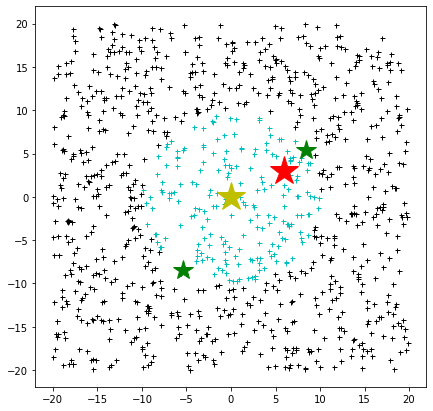

In [390]:
#Generate "training data" for LIME input
synth_data = []
synth_labels = []
nsamp = 1000
for _ in range(nsamp):
    point = np.random.uniform(low=-1*feat_range, high=1*feat_range, size=(n_dims,))
    point_node = Node(point, None)
    rec = query_nsphere_synth_model(point_node)
    synth_data.append(point)
    synth_labels.append(rec)
    
synth_data = np.asarray(synth_data)
synth_labels = np.asarray(synth_labels)
print("synth_data:",synth_data.shape)
print("synth_labels:",synth_labels.shape)

plt.rcParams["figure.figsize"] = (7,7)
for i in range(len(synth_data)):
    color = 'c+'
    if synth_labels[i] == 1:
        color = 'k+'
    plt.plot(synth_data[i][0],synth_data[i][1],color,markersize=5)
plt.plot(origin_node.position[0],origin_node.position[1],'y*',markersize=30)
plt.plot(source_node.position[0],source_node.position[1],'r*',markersize=30)

query_node = Node(np.asarray([4,-4]),0)
plt.plot(query_node_pos.position[0],query_node_pos.position[1],'g*',markersize=20)
plt.plot(query_node_neg.position[0],query_node_neg.position[1],'g*',markersize=20)

In [388]:
#Find GTI distance of interaction cluster on surface of nsphere

def gti_cluster_min(source_node, cluster_slope):

    # Solve for optimal cluster distance of nsphere gti synthetic model
    n_dims = len(source_node.position)
    
    #ax^2+bx+c=0
    c = 0
    b = 0
    a = 0

    for dim in range(n_dims):
        c += source_node.position[dim] ** 2
        b += 2 * source_node.position[dim] * cluster_slope[dim]
        a += cluster_slope[dim] ** 2
    c = c - boundary_threshold ** 2

    t_pos = (-b + (b**2 - 4*a*c) ** 0.5) / (2 * a)
    t_neg = (-b - (b**2 - 4*a*c) ** 0.5) / (2 * a)

    query_position_pos = source_node.position + cluster_slope * t_pos
    query_node_pos = Node(query_position_pos, 0)

    query_position_neg = source_node.position + cluster_slope * t_neg
    query_node_neg = Node(query_position_neg, 0)
    
    if np.array_equal(calc_feat_cluster(source_node, query_node_pos, feat_scaler), cluster_slope):
        return get_distance(source_node, query_node_pos, feat_scaler)
    else:
        return get_distance(source_node, query_node_neg, feat_scaler)
    

cluster_slope = np.asarray([-1,-1])
print("Min Cluster Distance:",gti_cluster_min(source_node, cluster_slope))

Min Cluster Distance: 16.099807519413545


In [400]:
np.random.seed(seed=0)
n_dims = 2
origin_node = Node(np.zeros(n_dims),0)

boundary_threshold = 10 #nsphere distance threshold from origin for class 0
feat_range = 20
feat_ranges = np.zeros(n_dims) + feat_range #Assume all features have max range 20
feat_scaler = 1 / feat_ranges


source_pos = np.linspace(1,n_dims,n_dims)
source_pos = np.flip(source_pos)
source_pos = source_pos/np.linalg.norm(source_pos) * boundary_threshold / 1.5

source_node = Node(source_pos,0) #Want to explain this value
query_nsphere_synth_model(source_node)
print("Source Position:",source_node.position)

Source Position: [5.96284794 2.98142397]


In [418]:
#Find top k feature interaction clusters
query_clusters = []
values = [-1, 0, 1]
for i in range(n_dims):
    for val in values:
        base_cluster = np.copy(origin_node.position)
        base_cluster[i] = val
        query_clusters.append(np.copy(base_cluster))
        for j in range(n_dims):
            if j > i:
                for val in values:
                    base_cluster[j] = val
                    query_clusters.append(np.copy(base_cluster))

In [420]:
for query_cluster_slope in query_clusters:
    distance = gti_cluster_min(source_node, query_cluster_slope)
    print(query_cluster_slope,":",distance)

[-1.  0.] : 15.508061982183676
[-1. -1.] : 16.099807519413545
[-1.  0.] : 15.508061982183676
[-1.  1.] : 9.854151799193753
[0. 0.] : nan
[ 0. -1.] : 11.009153689194582
[0. 0.] : nan
[0. 1.] : 5.0463057491951435
[1. 0.] : 3.582366102184797
[ 1. -1.] : 5.637781585635915
[1. 0.] : 3.582366102184797
[1. 1.] : 3.4506968787400285
[ 0. -1.] : 11.009153689194582
[0. 0.] : nan
[0. 1.] : 5.0463057491951435


/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/Users/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
